# DEEP LEARNING FOR PROTEIN STRUCTURES (Part 2)

## Amino acid and its environment

### 1. Can you recognize the amino acid by its structure?

Take a look at the following structures of amino acids. Can you distinguish different amino acids? This table of amino acids might help you in this task.
- Nitrogen: Blue
- Carbon: Green
- Oxygen: Red
- Sulfur: Yellow

<img src='https://drive.google.com/uc?id=1cltgrjlxVcVkx-TffmExqvBq7jpHxN_L'>

Now take a look at the following amino acids and recognize which structure they belong to.

<img src='https://drive.google.com/uc?id=14TWwgKaHNAjMHyF5Nae_yOT_jI5jkQjC'>

It was easy! no?
- Did the rotation of the amino acids or changes in the side-chain and backbon torsion angles influence your decisions?
- What deep learning approach do you propose for the classification of amino acids structures?
- Does traditional CNN do the job for us?

### 2. The environment around residue

<img src='https://drive.google.com/uc?id=1EA0YTjQV_GJsoJyD_TQ-tm2Puo7SXQWJ'>

- 6M0J is a crystal structure of SARS-CoV-2 spike receptor-binding domain (RBD) in interaction with Angiotensin-Converting Enzyme 2 (ACE2).

- Download the structure of biological assembly of this complex and visualize it in pymol.

- By what experimental method the structure of this complex is determined?

- Select spike glycoprotein (it's chain E). You can do this using command `select Spike, chain E`.

- Select ACE2 (it's chain A). You can do this using command `select ACE2, chain A`.

- Can you identify the interface between these two chains?

- Select residue 382 from chain A and rename it to `centralRes`. Use command `set_name sele, centralRes`. What is the name of this residue and what are its characteristics?

- Represent this residue with spheres using commands `show spheres, centralRes` and `set sphere_scale, 0.6`.

- Select the environment around this residue (6 $Å$) and name it `env`. Use command `select env, byres(centralRes around 6) + centralRes`.

- Show `env` as sticks. Use command `show sticks, env`.

- From the action menu (A) on `env` orient the visualisation on it.

- From the action menu (A) on `env` find all the polar contacts. `file->polar contacts->whitin selection`.

- Analyze the environment.

- Now repeat the same process for residue 487, 489, 498, and 500 from chain E.

- Present the protein in using balls and sticks

- Select a residue from the interface and change its torsion angles.


## A simple application: prediction of amino acid from its environment

### 1. Locally oriented cubes

A cube with the size of 24×24×24 $Å^3$ is placed on the residue and oriented according to the its backbone structure. Therefore, the architecture is invariant to 3D translations and rotations.

<img src='https://drive.google.com/uc?id=1cuaiYUTfhJwTeJzahumJKlySjV_an0Aa'>

<br>
<br>
<br>

For better understanding of the properties of locally oriented cubes please review [this article](https://academic.oup.com/bioinformatics/article/35/18/3313/5341430?login=true).

### 2. An end-to-end architecture to predict the amino acid from the environment

In [ ]:
import pandas as pd
import numpy as np
import logging
import seaborn as sns
from scipy import interp
from math import exp
from random import shuffle, random, seed, sample
import matplotlib.pyplot as plt
import time
import os, sys
import glob
import gc

!pip install pickle5
import pickle5

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, Dense, Dropout, Activation, Flatten, Concatenate, Dot, BatchNormalization, Add, Lambda
from tensorflow.keras.backend import ones, ones_like
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, log_loss
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255319 sha256=3159268b72ee50e9773a6a9ed7ef725aaea66080af76b1e8421095a1e8d4e290
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [ ]:
logging.basicConfig(filename='manager.log', filemode='w', format='%(levelname)s: %(message)s', level=logging.DEBUG)
mainlog = logging.getLogger('main')
logging.Logger

logging.Logger

In [ ]:
print('Your python version: {}'.format(sys.version_info.major))

Your python version: 3


In [ ]:
USE_TENSORFLOW_AS_BACKEND = True
FORCE_CPU = False

if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'
if FORCE_CPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
    print("GPU : "+tensorflow.test.gpu_device_name())
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

Your tensorflow version: 2.13.0
GPU : /device:GPU:0


#### 2.1 Model architecture based on 3D CNN

In [ ]:
def Conv_3D_model(input_shape):
  hidden_size1 = 200
  hidden_size2 = 20

  X_in = Input(shape=input_shape)

  H = Conv3D(20, kernel_size=(1, 1, 1), use_bias = True, padding = 'valid', activation='linear', kernel_initializer='he_uniform', input_shape=X_in.shape)(X_in)
  H = BatchNormalization()(H)
  H = Conv3D(20, kernel_size=(3, 3, 3), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = Conv3D(30, kernel_size=(4, 4, 4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = Conv3D(20, kernel_size=(4, 4, 4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = AveragePooling3D(pool_size=(4, 4, 4), strides=(4, 4, 4))(H)
  H = Flatten()(H)
  H = Dropout(0.4)(H)

  H = Dense(hidden_size1, activation='elu', name='layer1', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.2)(H)

  H = Dense(hidden_size2, activation='elu', name='layer2', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.1)(H)

  Y = Dense(20, activation='softmax')(H)

  _model = Model(inputs=[X_in], outputs=Y)
  _model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
  _model.summary()
  return _model

#### Questions
- What does the first layer of Conv3D do?
- What activation functions are used in this architecture?
- What is the difference between ELU and ReLU activation functions?
- What cost function are we trying to minimize?
- How many convolutional layers are used in this architecture?
- On which layers dropout technique is used? I invite you to review this [page](https://jmlr.org/papers/v15/srivastava14a.html).

#### 2.2 The input data: locally oriented cubes

Functions to serializing and de-serializing pickle object structure.

In [ ]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle5.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle5.load(f)

In [ ]:
def load_map(train_path):
    X_train, y_train, res_name = load_obj(train_path.replace('.pkl',''))
    return X_train, y_train, res_name

Download two datasets: residue samples with their environments and residue samples without their environments.

In [ ]:
!gdown --id '1ZuY9WMW5gewLVemz8h744KgUwMPyb9EP'
!gdown --id '1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd'

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZuY9WMW5gewLVemz8h744KgUwMPyb9EP
To: /content/traindata_30.zip
100% 8.90M/8.90M [00:00<00:00, 17.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd
To: /content/traindata_env_30.zip
100% 80.9M/80.9M [00:00<00:00, 146MB/s]


Decompress the two datasets.

In [ ]:
!unzip '/content/traindata_30.zip'
!unzip '/content/traindata_env_30.zip'

Archive:  /content/traindata_30.zip
  inflating: traindata_30/ALA_1cju_0_1_A_1--1cju_0_1_B_1_10.pkl  
  inflating: traindata_30/ALA_1h4r_0_1_A_1--1h4r_0_1_B_1_17.pkl  
  inflating: traindata_30/ALA_1ixm_0_1_A_1--1ixm_0_1_B_1_31.pkl  
  inflating: traindata_30/ALA_1l9r_0_1_A_1--1l9r_0_1_C_1_58.pkl  
  inflating: traindata_30/ALA_1n1e_0_1_A_1--1n1e_0_1_B_1_98.pkl  
  inflating: traindata_30/ALA_1o9q_0_1_B_1--1o9q_0_1_A_1_67.pkl  
  inflating: traindata_30/ALA_1o9q_0_1_B_1--1o9q_0_1_A_1_68.pkl  
  inflating: traindata_30/ALA_1rj9_0_1_B_1--1rj9_0_1_A_1_12.pkl  
  inflating: traindata_30/ALA_1rj9_0_1_B_1--1rj9_0_1_A_1_70.pkl  
  inflating: traindata_30/ALA_1su6_0_1_A_2--1su6_0_1_A_1_35.pkl  
  inflating: traindata_30/ALA_1yi1_0_1_A_4--1yi1_0_1_A_1_169.pkl  
  inflating: traindata_30/ALA_1yu2_0_1_A_3--1yu2_0_1_A_2_12.pkl  
  inflating: traindata_30/ALA_1zv8_0_2_I_1--1zv8_0_2_G_1_2.pkl  
  inflating: traindata_30/ALA_2a77_0_1_H_1--2a77_0_1_L_1_8.pkl  
  inflating: traindata_30/ALA_2af4_0_1_D_

Load the samples of the residues with or without their environments.

In [ ]:
#samples = glob.glob(os.path.join('traindata_30', '*.pkl'))
samples = glob.glob(os.path.join('traindata_env_30', '*.pkl')) #We will use this line in the end!

Function to reduce number of channels.

In [ ]:
channels = {'ALA':['C','N','O','CA','CB'],
            'ARG':['C','N','O','CA','CB','CG','CD','NE','CZ','NH1','NH2'],
            'ASN':['C','N','O','CA','CB','CG','ND2','OD1'],
            'ASP':['C','N','O','CA','CB','CG','OD1','OD2'],
            'CYS':['C','N','O','CA','CB','SG'],
            'GLN':['C','N','O','CA','CB','CG','CD','NE2','OE1'],
            'GLU':['C','N','O','CA','CB','CG','CD','OE1','OE2'],
            'GLY':['C','N','O','CA'],
            'HIS':['C','N','O','CA','CB','CG','CD2','ND1','CE1','NE2'],
            'ILE':['C','N','O','CA','CB','CG1','CG2','CD1'],
            'LEU':['C','N','O','CA','CB','CG','CD1','CD2'],
            'LYS':['C','N','O','CA','CB','CG','CD','CE','NZ'],
            'MET':['C','N','O','CA','CB','CG','SD','CE'],
            'PHE':['C','N','O','CA','CB','CG','CD1','CD2','CE1','CE2','CZ'],
            'PRO':['C','N','O','CA','CB','CG','CD'],
            'SER':['C','N','O','CA','CB','OG'],
            'THR':['C','N','O','CA','CB','CG2','OG1'],
            'TRP':['C','N','O','CA','CB','CG','CD1','CD2','CE2','CE3','NE1','CZ2','CZ3','CH2'],
            'TYR':['C','N','O','CA','CB','CG','CD1','CD2','CE1','CE2','CZ','OH'],
            'VAL':['C','N','O','CA','CB','CG1','CG2']}
v_dim = 24
n_channels = 4

all_channels = []
for aa, a_vector in channels.items():
    all_channels += a_vector

C_index, O_index, N_index, S_index = [], [], [], []
for i,a in enumerate(all_channels):
    if a[0] == "C":
        C_index.append(i)
    if a[0] == "O":
        O_index.append(i)
    if a[0] == "N":
        N_index.append(i)
    if a[0] == "S":
        S_index.append(i)

def reduce_channels(X):
    try:
        X_new = np.zeros(X.shape[:-1] + tuple([n_channels]))

        X_new[:,:,:,0] = X[:,:,:,C_index].sum(axis=3)
        X_new[:,:,:,1] = X[:,:,:,N_index].sum(axis=3)
        X_new[:,:,:,2] = X[:,:,:,O_index].sum(axis=3)
        X_new[:,:,:,3] = X[:,:,:,S_index].sum(axis=3)
    except:
        pass
    return X_new

In [ ]:
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
for sample in samples:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  y.append(np.array(sample_y))
X = np.array(X)
y = np.array(y)

Loading traindata_env_30/MET_1jwb_0_1_D_1--1jwb_0_1_B_1_46.pkl
Loading traindata_env_30/GLY_2bnu_0_1_A_1--2bnu_0_1_B_1_6.pkl
Loading traindata_env_30/HIS_1csr_0_1_A_2--1csr_0_1_A_1_116.pkl
Loading traindata_env_30/MET_2pa7_0_1_A_1--2pa7_0_1_B_1_37.pkl
Loading traindata_env_30/HIS_1viv_0_2_A_1--1viv_0_2_A_2_22.pkl
Loading traindata_env_30/SER_2vic_0_1_B_1--2vic_0_1_A_1_26.pkl
Loading traindata_env_30/LYS_1vqi_0_1_A_1--1vqi_0_1_A_2_31.pkl
Loading traindata_env_30/SER_2yc1_0_2_D_1--2yc1_0_2_E_1_26.pkl
Loading traindata_env_30/ASP_3rlm_0_1_F_1--3rlm_0_1_D_1_15.pkl
Loading traindata_env_30/TYR_5vjk_0_1_B_2--5vjk_0_1_B_1_54.pkl
Loading traindata_env_30/ALA_4dl0_0_1_K_1--4dl0_0_1_J_1_4.pkl
Loading traindata_env_30/LEU_2vic_0_1_B_1--2vic_0_1_A_1_41.pkl
Loading traindata_env_30/ASP_1h8e_0_1_G_1--1h8e_0_1_I_1_10.pkl
Loading traindata_env_30/HIS_3bkf_0_1_A_4--3bkf_0_1_A_2_12.pkl
Loading traindata_env_30/ASN_3kgc_0_1_B_1--3kgc_0_1_A_1_37.pkl
Loading traindata_env_30/ASN_1csr_0_1_A_2--1csr_0_1_A_1_

#### 2.3 Split data into train and test sets

In [ ]:
seed(int(np.round(np.random.random()*10)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
%xdel X
%xdel y
gc.collect()
print(X_test.shape)

(179, 24, 24, 24, 4)


#### 2.4 Training Process

In [ ]:
num_epochs = 20
batch_size = 10
v_dim = 24
n_features = 4

In [ ]:
input_shape=(v_dim,v_dim,v_dim,n_features)
model = Conv_3D_model(input_shape)

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, y_train, # Train the model using the training set...
                    batch_size=batch_size, epochs=num_epochs,
                    verbose=1, validation_split=0.3) # ...holding out 30% of the data for validation

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 24, 24, 4)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 24, 24, 24, 20)    100       
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 24, 20)    80        
 chNormalization)                                                
                                                                 
 conv3d_5 (Conv3D)           (None, 22, 22, 22, 20)    10820     
                                                                 
 batch_normalization_5 (Bat  (None, 22, 22, 22, 20)    80        
 chNormalization)                                                
                                                                 
 conv3d_6 (Conv3D)           (None, 19, 19, 19, 30)    3843

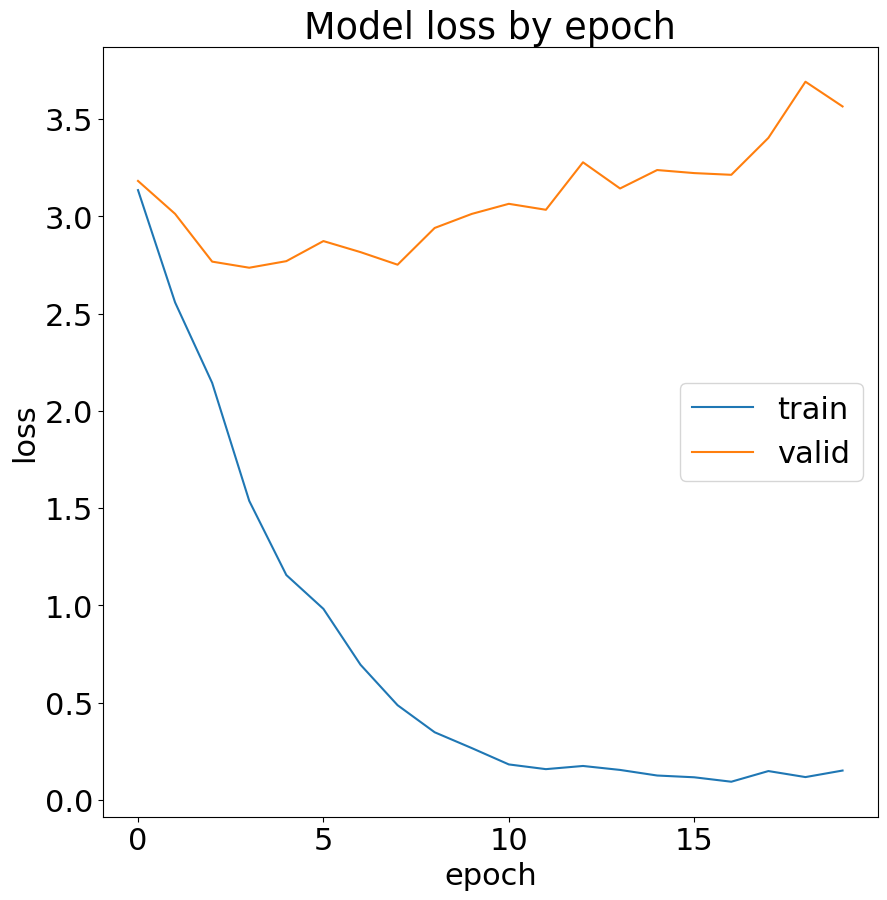

In [ ]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

Question: Is this evaluation of the performance reliable?

#### 2.5 Let's take a look at the performance of the model on test samples.

1/1 [==============================] - 0s 19ms/step


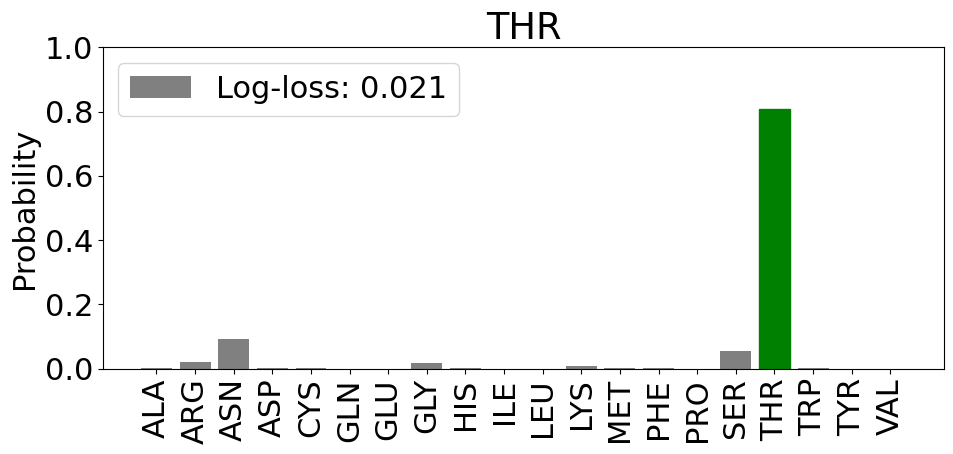

1/1 [==============================] - 0s 17ms/step


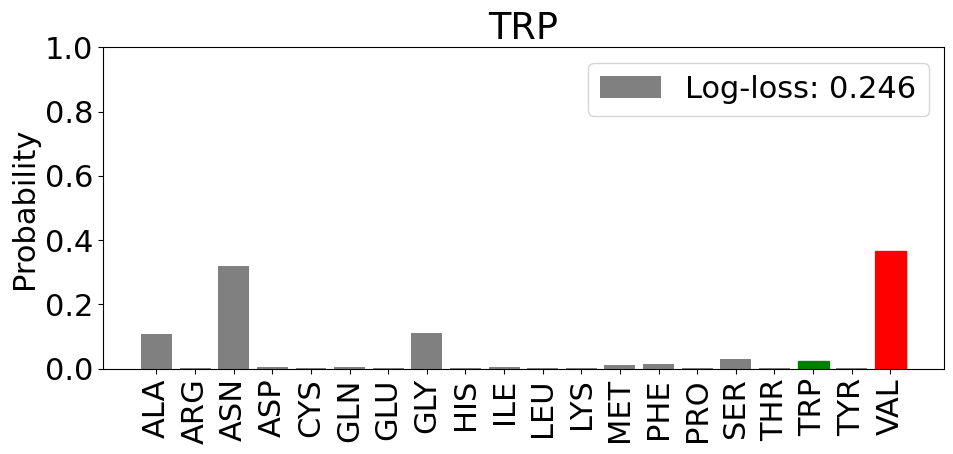

1/1 [==============================] - 0s 18ms/step


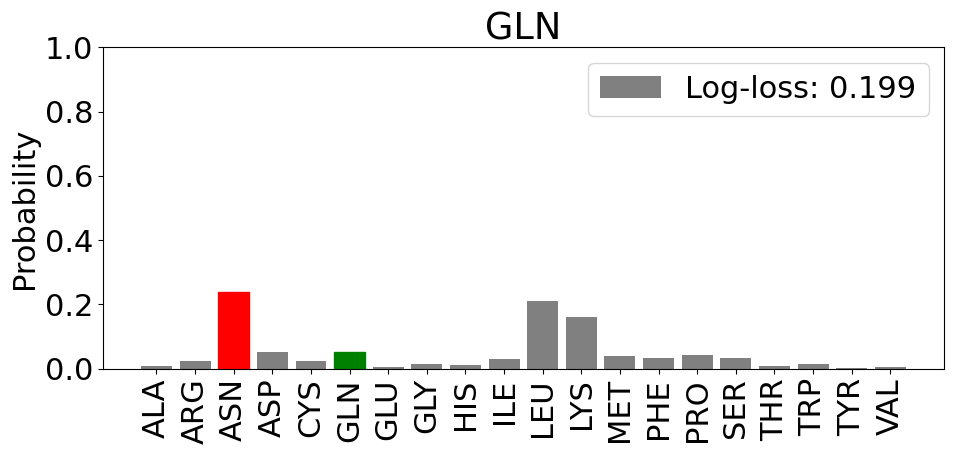

1/1 [==============================] - 0s 20ms/step


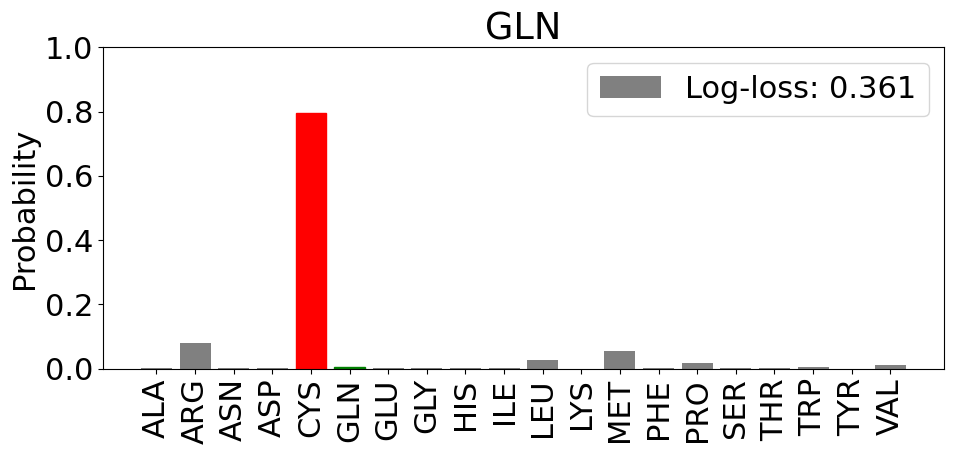

1/1 [==============================] - 0s 18ms/step


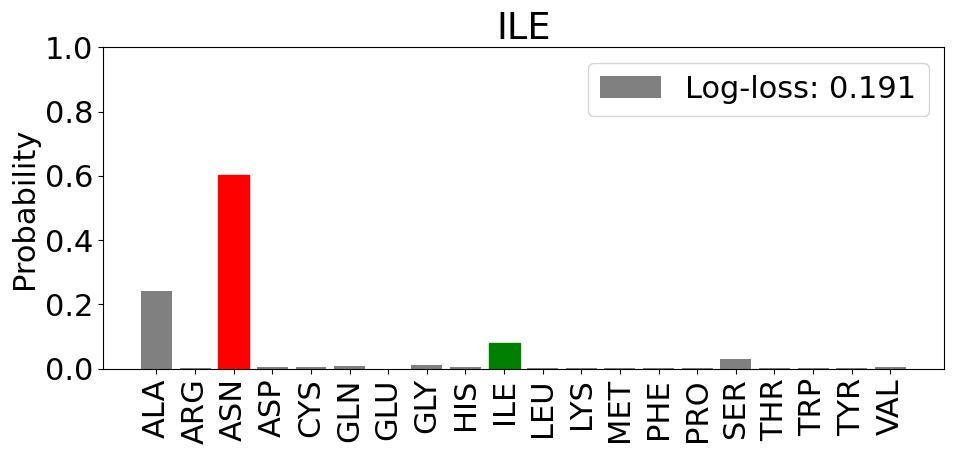

1/1 [==============================] - 0s 21ms/step


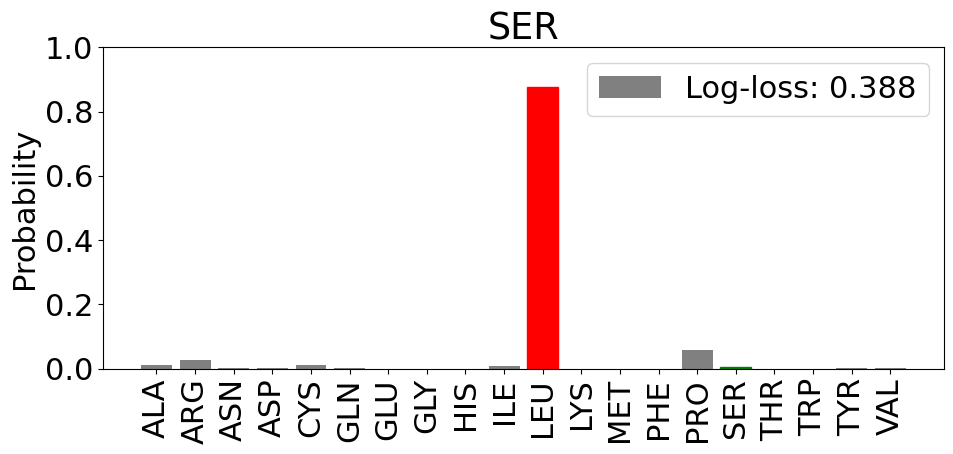

1/1 [==============================] - 0s 19ms/step


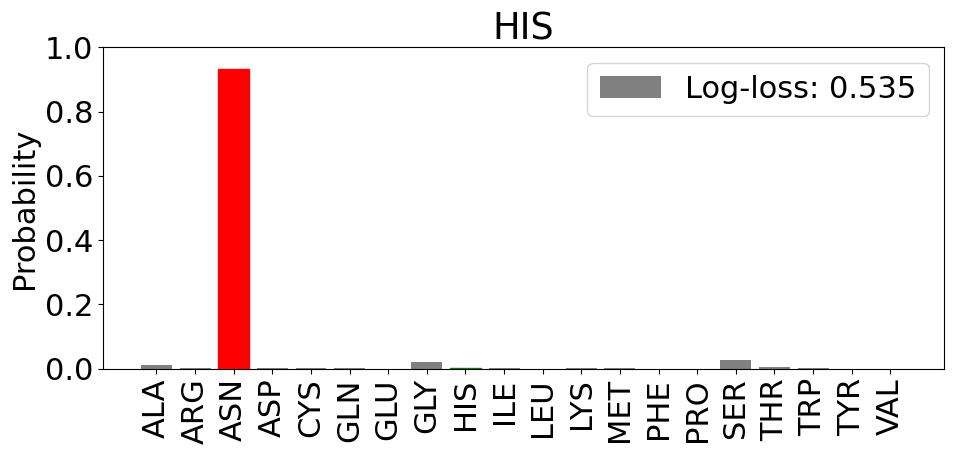

1/1 [==============================] - 0s 22ms/step


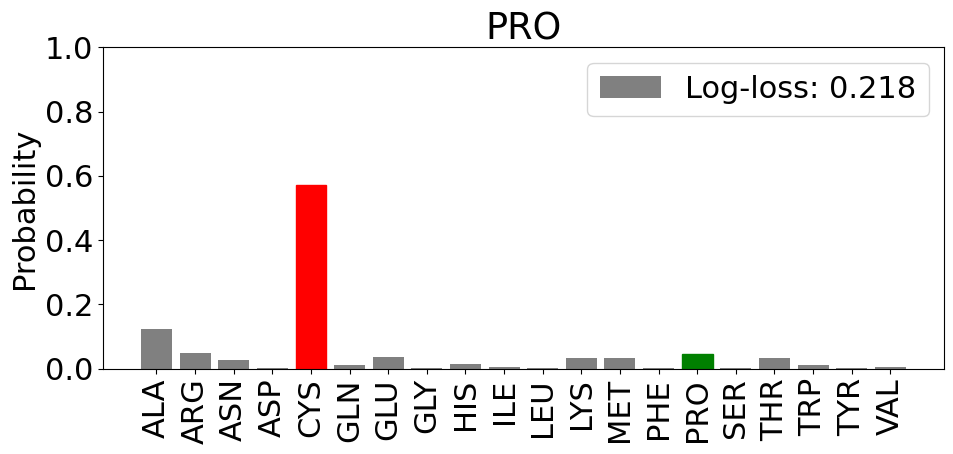

1/1 [==============================] - 0s 19ms/step


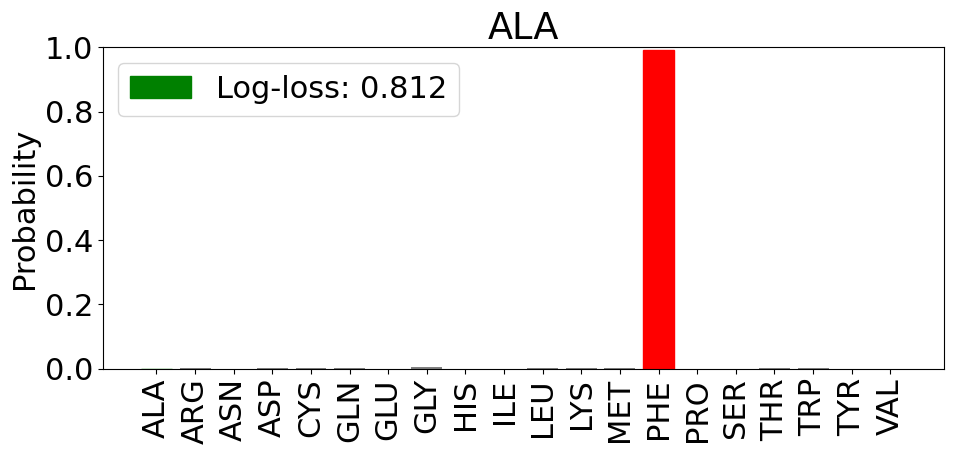

1/1 [==============================] - 0s 19ms/step


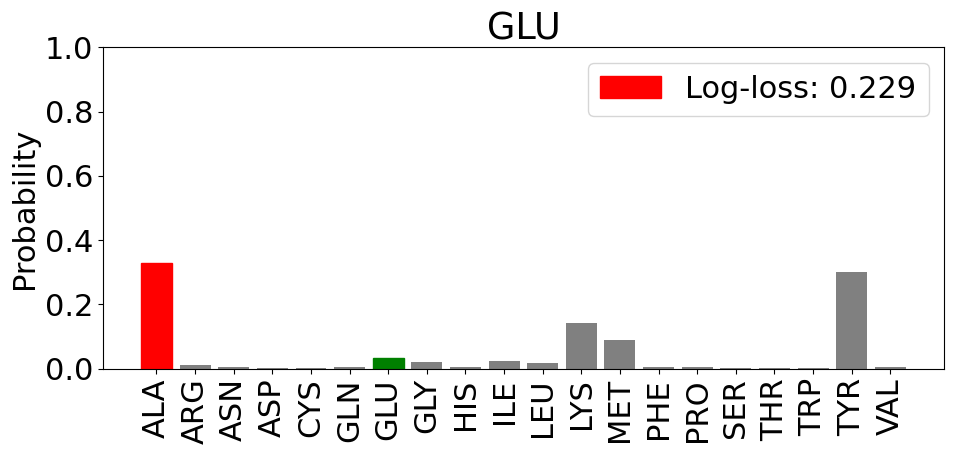

In [ ]:
list_aa = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO',
           'THR', 'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG',
           'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']
list_aa.sort()

plt.rcParams.update({'font.size': 22})

def do_pdf(pred, aa, ll):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    barlist = ax.bar(range(len(list_aa)), pred, color='gray', label='Log-loss: ' + str(ll))

    ax.set_xticks(range(len(list_aa)))
    ax.set_xticklabels(list_aa, rotation='vertical')

    barlist[pred.index(max(pred))].set_color('r')
    barlist[list_aa.index(aa)].set_color('g')

    ax.set_title(aa)
    ax.set_ylabel('Probability')
    ax.set_ylim(0,1)

    plt.tight_layout()
    plt.legend()
    plt.show()

for i in range(10):
  ind = np.random.choice(range(len(X_test)))
  X_t = np.array([X_test[ind]])
  y_t = y_test[ind]
  aa = list_aa[np.argwhere(y_t==1)[0][0]]
  pred = model.predict(X_t, batch_size=X_t.shape[0])[0]
  ll = round(log_loss(y_t, pred), 3)
  do_pdf(list(pred), aa, ll)

In [ ]:
#Clean the memory!
%xdel X
%xdel X_train
%xdel X_test
%xdel y
%xdel y_train
%xdel y_test
gc.collect()

NameError: name 'X' is not defined
NameError: name 'y' is not defined


16911

#### 2.5 Memorizing versus learning: not too similar not too different!
- Interpret the results. How is the performance of the machine?
- Now repeat the same process but this time load the residue samples with their environments.

#### 2.6 Discussion
What are the applications of such a model?

### 3. Transfer learning: use the trained model for a new downstream task

Now we want to use the model you have just trained to evaluate the environment of a residue. In this task we have two classes 0 and 1. Class 1 means the residue is comfortable in its environment (the environment is an acceptable local frame for the arrangment of the atoms) and class 0 means otherwise.

#### 3.1 The input data: locally oriented cubes representing acceptable and incorrect environments

Download the dataset: residue samples with their environments and 0 or 1 as target labels.

In [ ]:
!gdown --id '1p4v821pVgICBnWudFIuScFjPFiCzrF4F'

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1p4v821pVgICBnWudFIuScFjPFiCzrF4F
To: /content/traindata_env_class01.zip
100% 50.7M/50.7M [00:02<00:00, 18.0MB/s]


Decompress the dataset.

In [ ]:
!unzip '/content/traindata_env_class01.zip'

Archive:  /content/traindata_env_class01.zip
   creating: traindata_env_class01/
   creating: traindata_env_class01/0/
  inflating: traindata_env_class01/0/ALA_0.pkl  
  inflating: traindata_env_class01/0/ALA_1.pkl  
  inflating: traindata_env_class01/0/ALA_10.pkl  
  inflating: traindata_env_class01/0/ALA_11.pkl  
  inflating: traindata_env_class01/0/ALA_12.pkl  
  inflating: traindata_env_class01/0/ALA_13.pkl  
  inflating: traindata_env_class01/0/ALA_14.pkl  
  inflating: traindata_env_class01/0/ALA_15.pkl  
  inflating: traindata_env_class01/0/ALA_16.pkl  
  inflating: traindata_env_class01/0/ALA_17.pkl  
  inflating: traindata_env_class01/0/ALA_18.pkl  
  inflating: traindata_env_class01/0/ALA_19.pkl  
  inflating: traindata_env_class01/0/ALA_2.pkl  
  inflating: traindata_env_class01/0/ALA_3.pkl  
  inflating: traindata_env_class01/0/ALA_4.pkl  
  inflating: traindata_env_class01/0/ALA_5.pkl  
  inflating: traindata_env_class01/0/ALA_6.pkl  
  inflating: traindata_env_class01/0/A

Load the samples of the residues with target value 1 and 0.

In [ ]:
samples_0 = glob.glob(os.path.join('traindata_env_class01', '0', '*'))
samples_1 = glob.glob(os.path.join('traindata_env_class01', '1', '*'))

In [ ]:
samples = samples_1 + samples_0
shuffle(samples)

In [ ]:
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
for sample in samples_1[:25]:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  y.append(1)
for sample in samples_0[:25]:
  print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  y.append(0)
X = np.array(X)
y = np.array(y)

Loading traindata_env_class01/1/PHE_5.pkl
Loading traindata_env_class01/1/LEU_8.pkl
Loading traindata_env_class01/1/TYR_14.pkl
Loading traindata_env_class01/1/MET_11.pkl
Loading traindata_env_class01/1/CYS_15.pkl
Loading traindata_env_class01/1/SER_5.pkl
Loading traindata_env_class01/1/GLN_14.pkl
Loading traindata_env_class01/1/ASN_19.pkl
Loading traindata_env_class01/1/GLU_12.pkl
Loading traindata_env_class01/1/PRO_1.pkl
Loading traindata_env_class01/1/GLN_11.pkl
Loading traindata_env_class01/1/HIS_15.pkl
Loading traindata_env_class01/1/LEU_3.pkl
Loading traindata_env_class01/1/GLN_2.pkl
Loading traindata_env_class01/1/GLY_9.pkl
Loading traindata_env_class01/1/TYR_7.pkl
Loading traindata_env_class01/1/ALA_15.pkl
Loading traindata_env_class01/1/GLU_19.pkl
Loading traindata_env_class01/1/TRP_10.pkl
Loading traindata_env_class01/1/GLU_6.pkl
Loading traindata_env_class01/1/SER_16.pkl
Loading traindata_env_class01/1/LEU_11.pkl
Loading traindata_env_class01/1/PHE_7.pkl
Loading traindata_env

#### 3.2 Split data into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
del X, y
print(X_test.shape)

(15, 24, 24, 24, 4)


#### 3.3 Use the pre-trained model as feature extractor
Fot his purpose we will create an intermediate model similar to the pre-trained one except its output is the neurons of the second hidden layer of the fully connected network (`layer2`).

In [ ]:
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('layer2').output)

Now we extract rich features from the train and test sets.

In [ ]:
X_train_tr = intermediate_model.predict(X_train)

2/2 [==============================] - 1s 73ms/step


In [ ]:
print(X_train_tr.shape)
print(y_train.shape)

(35, 20)
(35,)


In [ ]:
X_test_tr = intermediate_model.predict(X_test)

1/1 [==============================] - 0s 330ms/step


#### 3.4 Training Process
Define a downstream model to classify the environments. This model can be non-linear such as a neural network or a linear model such as logistic regression.

In [ ]:
def nn_model(input_shape):
    hidden_size1 = 10
    hidden_size2 = 5
    X_in = Input(shape=input_shape)
    H = Dense(hidden_size1, activation='elu', name='layer1')(X_in)
    H = Dense(hidden_size2, activation='elu', name='layer2')(H)
    Y = Dense(1, activation='sigmoid')(H)
    _model = Model(inputs=X_in, outputs=Y)
    _model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
    _model.summary()
    return _model

In [ ]:
num_epochs = 20
batch_size = 10
n_features_tr = 20 #hidden_size2 of the pre-trained model

In [ ]:
input_shape=(n_features_tr)
model_tr = nn_model(input_shape)

# --------------------------------------
# Training
# --------------------------------------
history = model_tr.fit(X_train_tr, y_train, # Train the model using the training set...
                    batch_size=batch_size, epochs=num_epochs,
                    verbose=1, validation_split=0.3) # ...holding out 30% of the data for validation

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 layer1 (Dense)              (None, 10)                210       
                                                                 
 layer2 (Dense)              (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 271 (1.06 KB)
Trainable params: 271 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3/3 [==============================] - 2s 85ms/step - loss: 0.9883 - val_loss: 1.1616
Epoch 2/20
3/3 [==============================] - 0s 17ms/step -

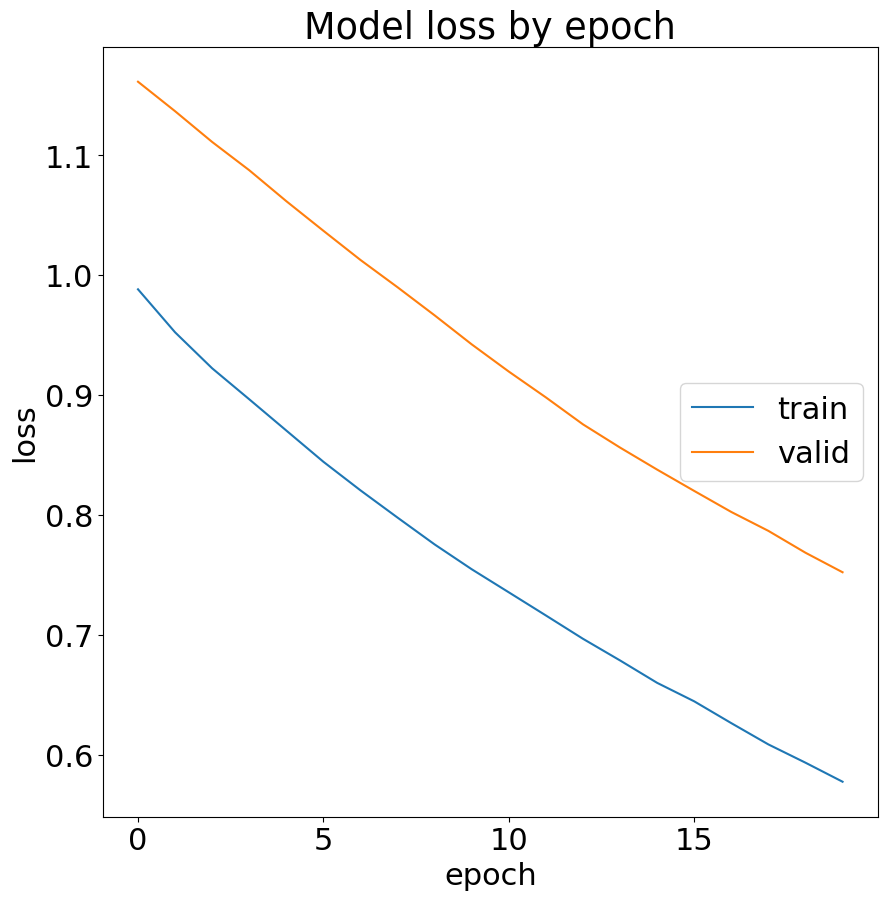

In [ ]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()

1/1 [==============================] - 0s 65ms/step
Transferred learning ROC AUC 0.889


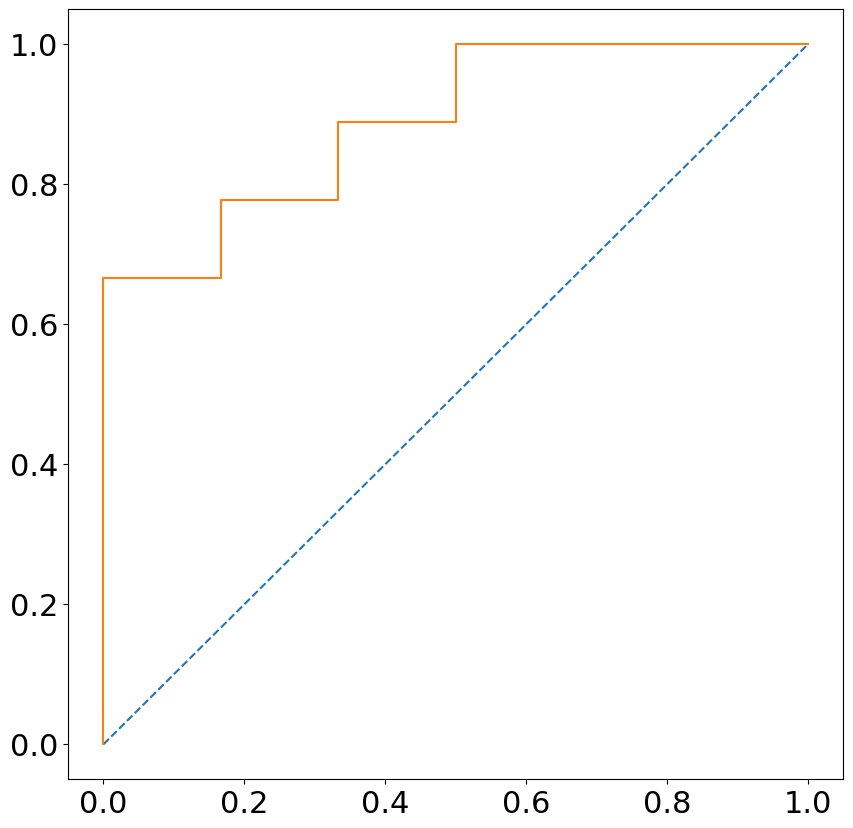

In [ ]:
noskill = [0]*len(y_test)
y_pred = model_tr.predict(X_test_tr)
roc_auc = roc_auc_score(y_test, y_pred)
print('Transferred learning ROC AUC %.3f' % roc_auc)

ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill)
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='NoSkill')
plt.plot(fpr, tpr, linestyle='-', label='Transferred Learning')
plt.show()

#plot_roc_curve(y_test, naive_probs, y_pred)

#### 3.5 Discussion

Designed by Yasser MOHSENI BEHBAHANI, LCQB, Sorbonne Université, 2021

<img src='https://drive.google.com/uc?id=1shvaqXgnRa2aCji30gJ02hwI_Ux6NEp6'>
